# **Check GPU**

In [1]:
# Check the GPU model:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-981912e7-585f-49c2-1ad9-600372b88670)


In [2]:
## Install tf-nightly (required until 2.13.0+ is the default in Google Colab)
#!pip install -U -q tf-nightly

# Check TensorFlow version (should be minimum 2.4.0+ but 2.13.0+ is better)
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

TensorFlow version: 2.14.0-dev20230620
Notebook last run (end-to-end): 2023-06-27 18:09:06.458769


# **Helper Functions**

In [3]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

[INFO] 'helper_functions.py' already exists, skipping download.


In [4]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

# **Download Data**

In [5]:
import opendatasets as od

In [6]:
# Download data from Kaggle
od.download("https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition")

Skipping, found downloaded files in ".\fruit-and-vegetable-image-recognition" (use force=True to force download)


In [7]:
# Assign directories
train_dir = "fruit-and-vegetable-image-recognition/train/"
test_dir = "fruit-and-vegetable-image-recognition/test/"
val_dir = "fruit-and-vegetable-image-recognition/validation/"

In [8]:
# How many images/classes are there?
walk_through_dir("fruit-and-vegetable-image-recognition")

There are 3 directories and 0 images in 'fruit-and-vegetable-image-recognition'.
There are 36 directories and 0 images in 'fruit-and-vegetable-image-recognition\test'.
There are 0 directories and 10 images in 'fruit-and-vegetable-image-recognition\test\apple'.
There are 0 directories and 9 images in 'fruit-and-vegetable-image-recognition\test\banana'.
There are 0 directories and 10 images in 'fruit-and-vegetable-image-recognition\test\beetroot'.
There are 0 directories and 10 images in 'fruit-and-vegetable-image-recognition\test\bell pepper'.
There are 0 directories and 10 images in 'fruit-and-vegetable-image-recognition\test\cabbage'.
There are 0 directories and 10 images in 'fruit-and-vegetable-image-recognition\test\capsicum'.
There are 0 directories and 10 images in 'fruit-and-vegetable-image-recognition\test\carrot'.
There are 0 directories and 10 images in 'fruit-and-vegetable-image-recognition\test\cauliflower'.
There are 0 directories and 10 images in 'fruit-and-vegetable-image

In [9]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for predic

val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               shuffle=False) # don't shuffle test data for predic

Found 3115 files belonging to 36 classes.
Found 359 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


In [10]:
## Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [11]:
## What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 36), dtype=tf.float32, name=None))>

In [12]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  """)


  Image shape: (32, 224, 224, 3)
  Image dtype: <dtype: 'float32'>
  


In [13]:
# What does an image tensor look like?
image

<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[2.94566326e+01, 2.80644150e+01, 0.00000000e+00],
         [2.85446434e+01, 1.95089283e+01, 1.01785707e+00],
         [1.81517849e+01, 1.21517849e+01, 3.27168077e-01],
         ...,
         [2.72141113e+01, 2.62319679e+01, 9.58493948e-01],
         [3.33196182e+01, 2.55378017e+01, 3.22838473e+00],
         [2.69642868e+01, 1.94732151e+01, 0.00000000e+00]],

        [[1.61766567e+01, 1.40338011e+01, 7.03443885e-01],
         [2.58985958e+01, 1.65325260e+01, 1.89285660e+00],
         [2.08839302e+01, 1.11875010e+01, 2.86543369e+00],
         ...,
         [2.56428223e+01, 3.52862320e+01, 2.35776424e+00],
         [2.21641445e+01, 2.12325611e+01, 2.14355469e-01],
         [2.10159531e+01, 1.50159531e+01, 1.96238160e+00]],

        [[1.24553576e+01, 1.04228325e+01, 3.25255245e-02],
         [1.25529346e+01, 8.55293465e+00, 9.75766778e-02],
         [2.00714302e+01, 1.17142868e+01, 0.00000000e+00],
         ...,
         [

In [14]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=255.0>)

In [15]:
# Create checkpoint callback to save model for later use
checkpoint_path = "fruit_and_vegetable_image_recognition_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights

# **Create modelling callbacks**

In [16]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

# **Setup mixed precision training**

In [17]:
## Turn on mixed precision training
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

In [18]:
# mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

In [19]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # layers.Rescaling(1./255) # keep for ResNet, remove for EfficientNet
], name ="data_augmentation")

In [20]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.resnet.ResNet101(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
# x = layers.Dense(len(train_data_all_10_percent.class_names))(x) # same number of outputs as classes
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
## Separate activation of output layer so we can output float32 activations
# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

In [21]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 resnet101 (Functional)      (None, None, None, 2048   42658176  
                             )                                   
                                                                 
 global_average_pooling (Gl  (None, 2048)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 36)                73764     
                                                             

In [22]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_fruit_and_vegetable_image_recognition = model.fit(train_data,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[create_tensorboard_callback("training_logs", 
                                                                                  "ResNet101_feature_extract"),
                                                      model_checkpoint])

Saving TensorBoard log files to: training_logs/ResNet101_feature_extract/20230627-180912
Epoch 1/5
98/98 [==============================] - 175s 2s/step - loss: 2.1078 - accuracy: 0.4347 - val_loss: 0.7803 - val_accuracy: 0.7812
Epoch 2/5
98/98 [==============================] - 172s 2s/step - loss: 1.0387 - accuracy: 0.6957 - val_loss: 0.5834 - val_accuracy: 0.7812
Epoch 3/5
98/98 [==============================] - 170s 2s/step - loss: 0.8014 - accuracy: 0.7579 - val_loss: 0.3924 - val_accuracy: 0.8438
Epoch 4/5
98/98 [==============================] - 168s 2s/step - loss: 0.6991 - accuracy: 0.7929 - val_loss: 0.2777 - val_accuracy: 0.9375
Epoch 5/5
98/98 [==============================] - 170s 2s/step - loss: 0.6137 - accuracy: 0.8096 - val_loss: 0.3603 - val_accuracy: 0.8750


In [23]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

12/12 [==============================] - 18s 1s/step - loss: 0.3291 - accuracy: 0.8969


[0.32909247279167175, 0.8969359397888184]

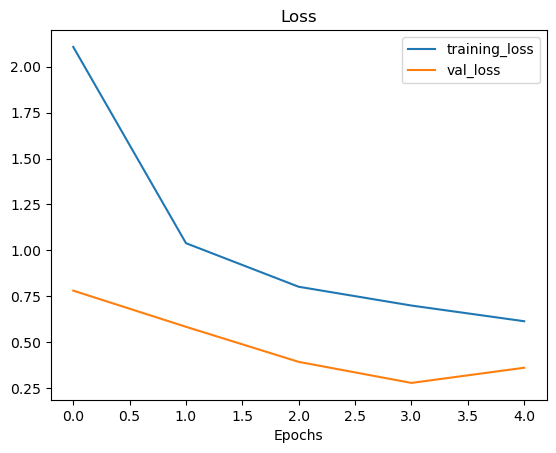

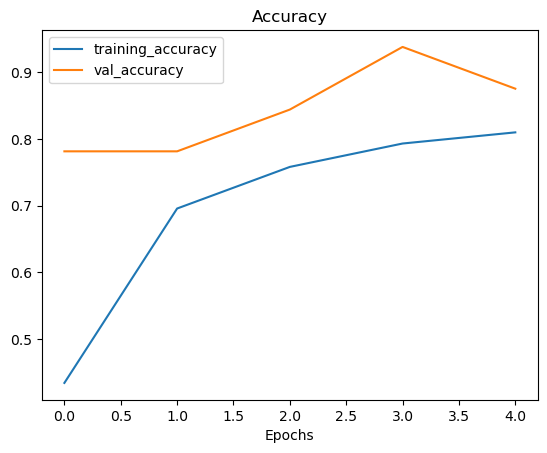

In [24]:
plot_loss_curves(history_fruit_and_vegetable_image_recognition)

# **A couple more callbacks**

In [25]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [26]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

# **Fine-tuning**

In [27]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [28]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [29]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
resnet101 True
global_average_pooling True
output_layer True


In [30]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [31]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_fruit_and_vegetable_image_recognition_fine_tune = model.fit(train_data,
                                                          epochs=fine_tune_epochs,
                                                          validation_data=test_data,
                                                          validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                          initial_epoch=history_fruit_and_vegetable_image_recognition.epoch[-1]) # start from previous last epoch

Epoch 5/10
98/98 [==============================] - 182s 2s/step - loss: 0.4833 - accuracy: 0.8620 - val_loss: 0.3179 - val_accuracy: 0.9062
Epoch 6/10
98/98 [==============================] - 174s 2s/step - loss: 0.4364 - accuracy: 0.8726 - val_loss: 0.3137 - val_accuracy: 0.9062
Epoch 7/10
98/98 [==============================] - 162s 2s/step - loss: 0.4155 - accuracy: 0.8783 - val_loss: 0.4009 - val_accuracy: 0.8438
Epoch 8/10
98/98 [==============================] - 166s 2s/step - loss: 0.3769 - accuracy: 0.8864 - val_loss: 0.3107 - val_accuracy: 0.8750
Epoch 9/10
98/98 [==============================] - 169s 2s/step - loss: 0.3514 - accuracy: 0.8950 - val_loss: 0.2771 - val_accuracy: 0.9062
Epoch 10/10
98/98 [==============================] - 171s 2s/step - loss: 0.3313 - accuracy: 0.9079 - val_loss: 0.3351 - val_accuracy: 0.8438


In [32]:
# Evaluate fine-tuned model on the whole test dataset
results_fine_tune_model = model.evaluate(test_data)
results_fine_tune_model

12/12 [==============================] - 18s 1s/step - loss: 0.2536 - accuracy: 0.9220


[0.25359708070755005, 0.9220055937767029]

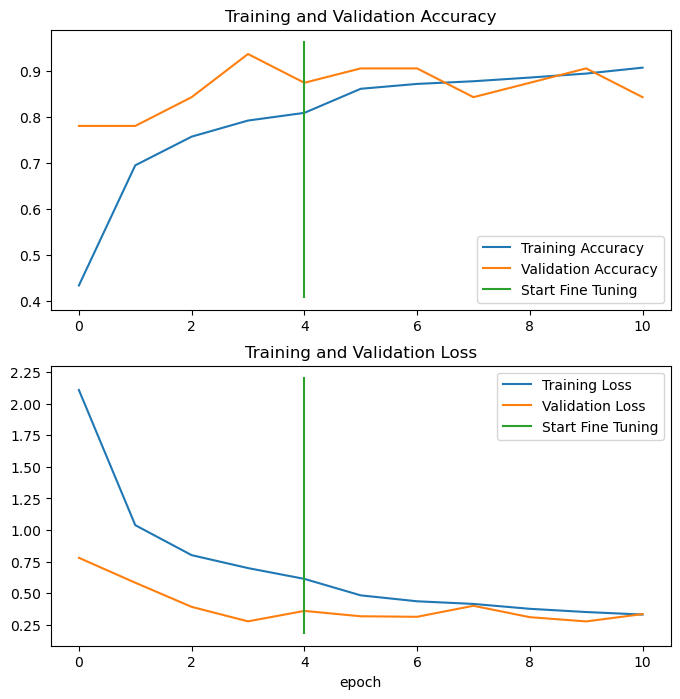

In [33]:
compare_historys(original_history=history_fruit_and_vegetable_image_recognition,
                 new_history=history_fruit_and_vegetable_image_recognition_fine_tune,
                 initial_epochs=5)

# **Saving our trained model**

In [34]:
# # Save model to drive so it can be used later 
# model.save("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")

# **Making predictions with our trained model**

In [35]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

12/12 [==============================] - 19s 1s/step


In [36]:
# How many predictions are there?
len(pred_probs)

359

In [37]:
# What's the shape of our predictions?
pred_probs.shape

(359, 36)

In [38]:
# What's the shape of our predictions?
pred_probs.shape

(359, 36)

In [39]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 36
What prediction probability sample 0 looks like:
 [9.9360824e-01 2.9610304e-11 5.4870156e-07 7.0610318e-09 7.1184345e-13
 7.7499989e-09 2.8932026e-09 9.8026968e-12 6.3953869e-09 9.3776471e-12
 6.1101083e-11 4.6169468e-08 4.9282687e-12 6.1793675e-13 2.9625136e-09
 2.1058051e-11 2.9789245e-08 1.3619332e-07 8.9120658e-09 1.5752890e-07
 3.3323420e-06 5.8677921e-05 3.2397857e-05 2.6349320e-05 1.5217039e-11
 1.4579142e-11 6.2552216e-03 1.2506780e-07 2.5393245e-08 2.8794780e-09
 6.6100528e-12 5.1868848e-12 1.8464150e-10 2.4488802e-06 1.0080513e-05
 2.1530693e-06]
The class with the highest predicted probability by the model for sample 0: 0


In [40]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0,  0, 34,  0,  0,  0,  0, 26], dtype=int64)

In [41]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [42]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

359

# **Evaluating models predictions**

In [43]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.9220055710306406

In [44]:
## Does the evaluate method compare to the Scikit-Learn measured accuracy?
# import numpy as np
# print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

In [45]:
# We'll import our make_confusion_matrix function from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py 
# But if you run it out of the box, it doesn't really work for 101 classes...
# the cell below adds a little functionality to make it readable.
from helper_functions import make_confusion_matrix

In [46]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [47]:
# Get the class names
class_names = test_data.class_names
class_names

['apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon']

In [48]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.88      0.78      0.82         9
           2       0.91      1.00      0.95        10
           3       0.75      0.60      0.67        10
           4       1.00      1.00      1.00        10
           5       0.62      0.80      0.70        10
           6       0.82      0.90      0.86        10
           7       0.91      1.00      0.95        10
           8       0.80      0.80      0.80        10
           9       0.77      1.00      0.87        10
          10       0.83      1.00      0.91        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      0.90      0.95        10
          14       1.00      0.90      0.95        10
          15       1.00      0.80      0.89        10
          16       1.00      1.00      1.00        10
          17       1.00    

In [50]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.8,
  'recall': 0.8,
  'f1-score': 0.8000000000000002,
  'support': 10},
 '1': {'precision': 0.875,
  'recall': 0.7777777777777778,
  'f1-score': 0.823529411764706,
  'support': 9},
 '2': {'precision': 0.9090909090909091,
  'recall': 1.0,
  'f1-score': 0.9523809523809523,
  'support': 10},
 '3': {'precision': 0.75,
  'recall': 0.6,
  'f1-score': 0.6666666666666665,
  'support': 10},
 '4': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10},
 '5': {'precision': 0.6153846153846154,
  'recall': 0.8,
  'f1-score': 0.6956521739130435,
  'support': 10},
 '6': {'precision': 0.8181818181818182,
  'recall': 0.9,
  'f1-score': 0.8571428571428572,
  'support': 10},
 '7': {'precision': 0.9090909090909091,
  'recall': 1.0,
  'f1-score': 0.9523809523809523,
  'support': 10},
 '8': {'precision': 0.8,
  'recall': 0.8,
  'f1-score': 0.8000000000000002,
  'support': 10},
 '9': {'precision': 0.7692307692307693,
  'recall': 1.0,
  'f1-score': 0.8695652173913044,
  'suppo

In [51]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple': 0.8000000000000002,
 'banana': 0.823529411764706,
 'beetroot': 0.9523809523809523,
 'bell pepper': 0.6666666666666665,
 'cabbage': 1.0,
 'capsicum': 0.6956521739130435,
 'carrot': 0.8571428571428572,
 'cauliflower': 0.9523809523809523,
 'chilli pepper': 0.8000000000000002,
 'corn': 0.8695652173913044,
 'cucumber': 0.9090909090909091,
 'eggplant': 1.0,
 'garlic': 1.0,
 'ginger': 0.9473684210526316,
 'grapes': 0.9473684210526316,
 'jalepeno': 0.888888888888889,
 'kiwi': 1.0,
 'lemon': 1.0,
 'lettuce': 1.0,
 'mango': 0.8571428571428572,
 'onion': 1.0,
 'orange': 0.9523809523809523,
 'paprika': 0.888888888888889,
 'pear': 1.0,
 'peas': 1.0,
 'pineapple': 1.0,
 'pomegranate': 0.9523809523809523,
 'potato': 0.8421052631578948,
 'raddish': 0.9,
 'soy beans': 1.0,
 'spinach': 1.0,
 'sweetcorn': 0.8235294117647058,
 'sweetpotato': 0.9473684210526316,
 'tomato': 1.0,
 'turnip': 0.9523809523809523,
 'watermelon': 0.9473684210526316}

In [52]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
18    lettuce       1.0
20      onion       1.0
17      lemon       1.0
16       kiwi       1.0
23       pear       1.0

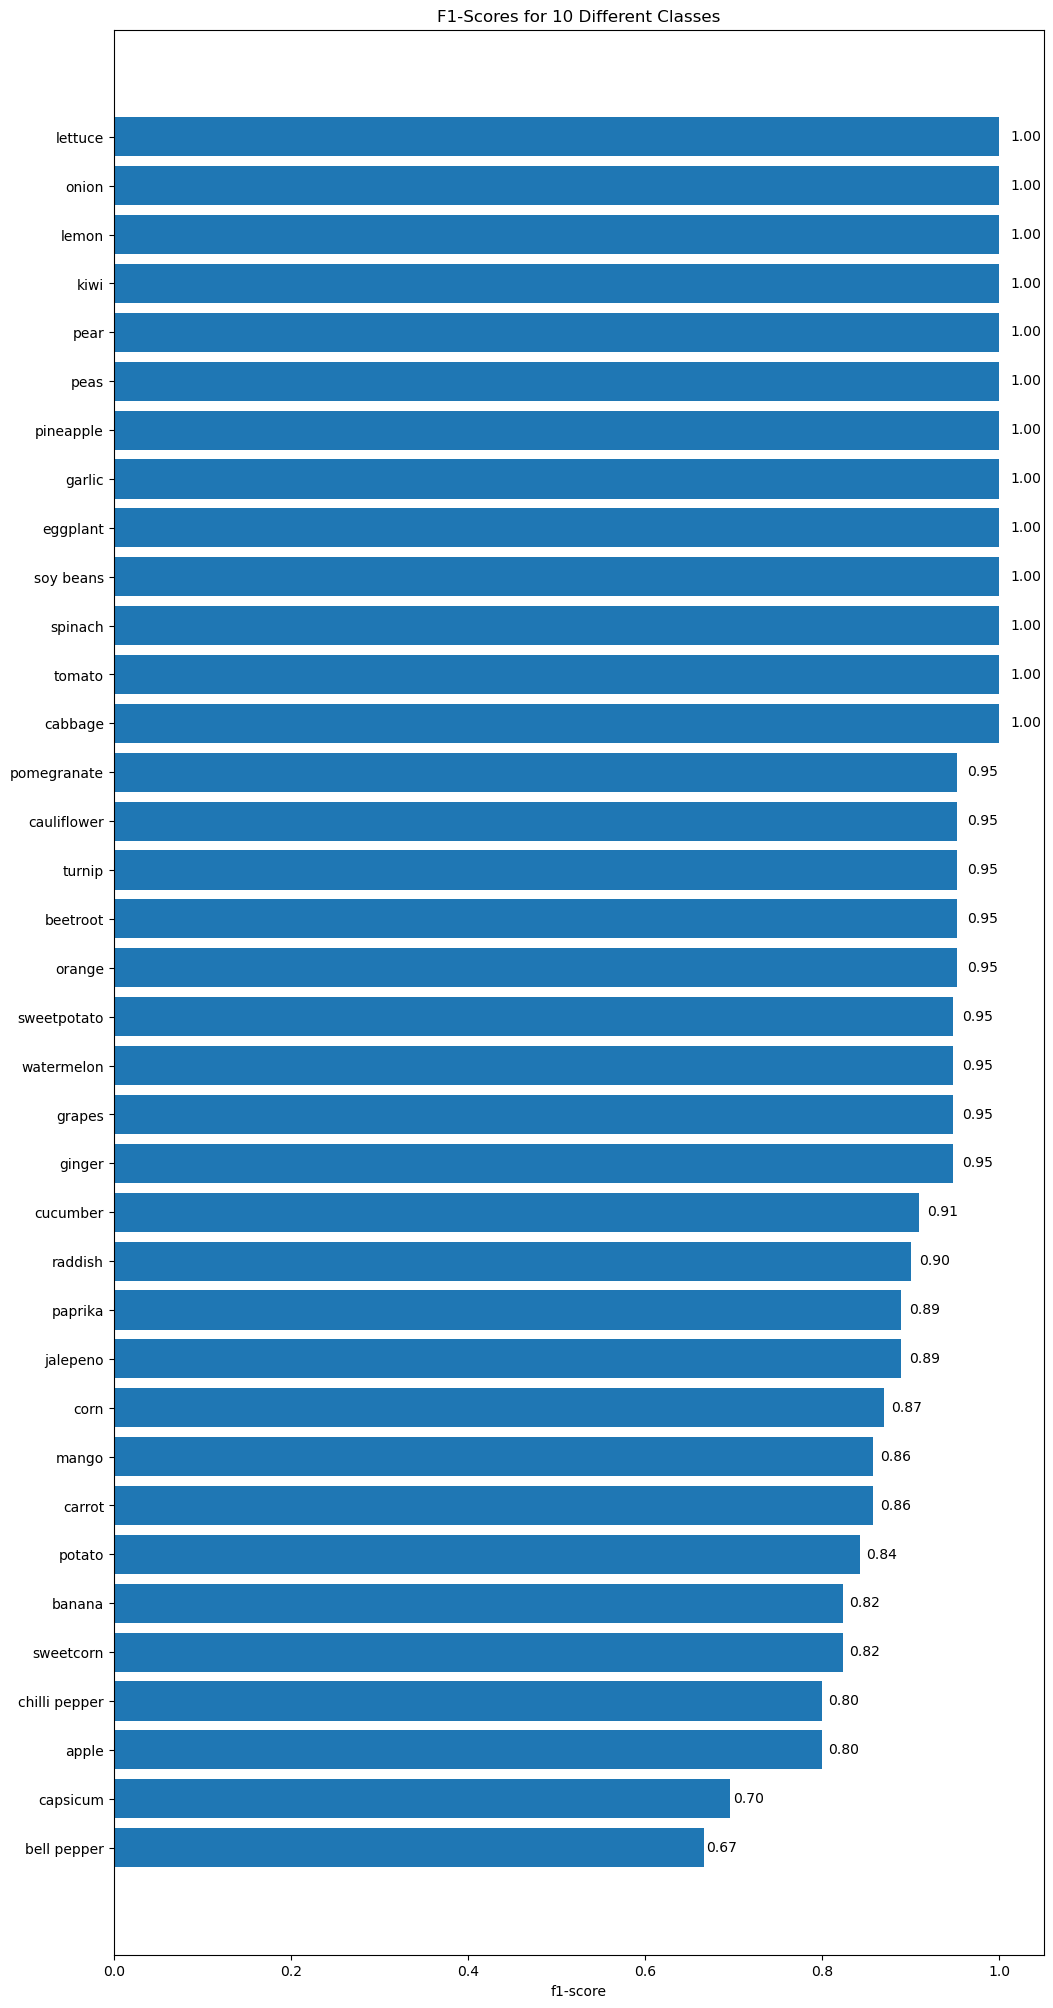

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

### Let's load a few random images from the test dataset, make predictions on them, and plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.


In [54]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 79ms/step


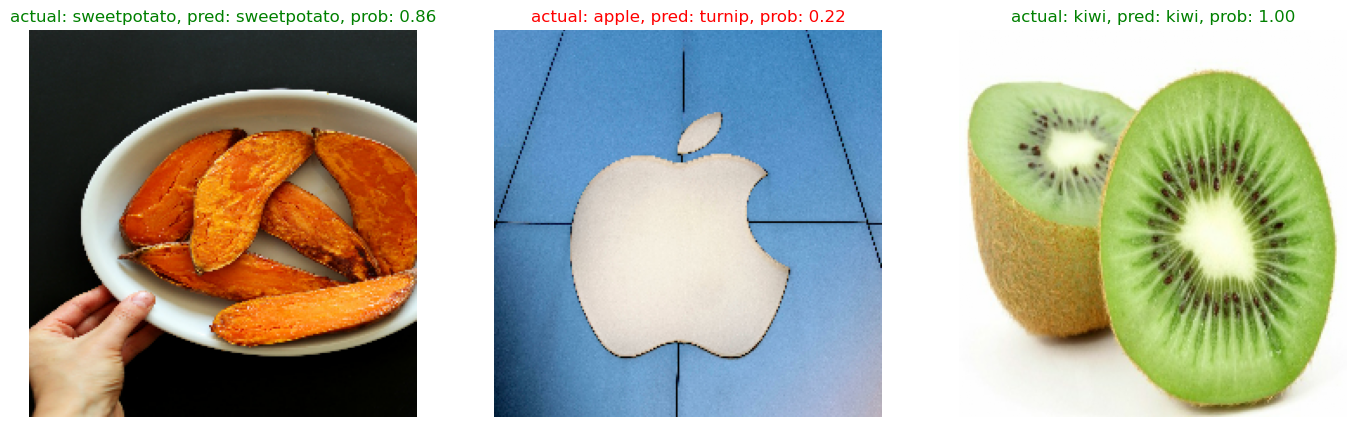

In [55]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

# **Finding the most wrong predictions**

In [56]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("fruit-and-vegetable-image-recognition/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'fruit-and-vegetable-image-recognition\\test\\apple\\Image_1.jpg',
 b'fruit-and-vegetable-image-recognition\\test\\apple\\Image_10.jpg',
 b'fruit-and-vegetable-image-recognition\\test\\apple\\Image_2.jpg',
 b'fruit-and-vegetable-image-recognition\\test\\apple\\Image_3.jpg',
 b'fruit-and-vegetable-image-recognition\\test\\apple\\Image_4.jpg',
 b'fruit-and-vegetable-image-recognition\\test\\apple\\Image_5.jpg',
 b'fruit-and-vegetable-image-recognition\\test\\apple\\Image_6.JPG',
 b'fruit-and-vegetable-image-recognition\\test\\apple\\Image_7.jpg',
 b'fruit-and-vegetable-image-recognition\\test\\apple\\Image_8.jpg',
 b'fruit-and-vegetable-image-recognition\\test\\apple\\Image_9.jpg']

In [57]:
np.shape(filepaths)
print(len(filepaths))

340


In [58]:
input1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
filepaths.extend(input1)

How about to append?
How about to extend the filepath?

In [59]:
print(len(filepaths))
print(len(y_labels))
print(len(pred_classes))
print(len(pred_probs))
print(len(class_names))

359
359
359
359
36


In [60]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  y_true  y_pred  \
0  b'fruit-and-vegetable-image-recognition\\test\...       0       0   
1  b'fruit-and-vegetable-image-recognition\\test\...       0       0   
2  b'fruit-and-vegetable-image-recognition\\test\...       0       0   
3  b'fruit-and-vegetable-image-recognition\\test\...       0       0   
4  b'fruit-and-vegetable-image-recognition\\test\...       0      34   

   pred_conf y_true_classname y_pred_classname  
0   0.993608            apple            apple  
1   0.993608            apple            apple  
2   0.999946            apple            apple  
3   0.952209            apple            apple  
4   0.216788            apple           turnip

In [61]:
# 3. Are predictions correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'fruit-and-vegetable-image-recognition\\test\...       0       0   
1  b'fruit-and-vegetable-image-recognition\\test\...       0       0   
2  b'fruit-and-vegetable-image-recognition\\test\...       0       0   
3  b'fruit-and-vegetable-image-recognition\\test\...       0       0   
4  b'fruit-and-vegetable-image-recognition\\test\...       0      34   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.993608            apple            apple          True  
1   0.993608            apple            apple          True  
2   0.999946            apple            apple          True  
3   0.952209            apple            apple          True  
4   0.216788            apple           turnip         False

In [62]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
271  b'fruit-and-vegetable-image-recognition\\test\...      27       0   
58   b'fruit-and-vegetable-image-recognition\\test\...       5       8   
352                                                0.0      35       7   
318  b'fruit-and-vegetable-image-recognition\\test\...      31       9   
141  b'fruit-and-vegetable-image-recognition\\test\...      14      19   
227  b'fruit-and-vegetable-image-recognition\\test\...      22       8   
152  b'fruit-and-vegetable-image-recognition\\test\...      15      10   
326  b'fruit-and-vegetable-image-recognition\\test\...      32       6   
54   b'fruit-and-vegetable-image-recognition\\test\...       5       3   
192  b'fruit-and-vegetable-image-recognition\\test\...      19      21   
225  b'fruit-and-vegetable-image-recognition\\test\...      22       5   
277  b'fruit-and-vegetable-image-recognition\\test\...      27       0   
286  b'fruit-and-vegetable-image-recognition\\test\...      28       2   
314  b'fruit-and-vegetable-image-recognition\\test\...      31       9   
36   b'fruit-and-vegetable-image-recognition\\test\...       3       5   
38   b'fruit-and-vegetable-image-recognition\\test\...       3       5   
29   b'fruit-and-vegetable-image-recognition\\test\...       3       5   
309  b'fruit-and-vegetable-image-recognition\\test\...      31       9   
156  b'fruit-and-vegetable-image-recognition\\test\...      15      10   
32   b'fruit-and-vegetable-image-recognition\\test\...       3       5   

     pred_conf y_true_classname y_pred_classname  pred_correct  
271   0.995821           potato            apple         False  
58    0.942189         capsicum    chilli pepper         False  
352   0.929161       watermelon      cauliflower         False  
318   0.922358        sweetcorn             corn         False  
141   0.899515           grapes            mango         False  
227   0.899097          paprika    chilli pepper         False  
152   0.866202         jalepeno         cucumber         False  
326   0.797269      sweetpotato           carrot         False  
54    0.788573         capsicum      bell pepper         False  
192   0.664833            mango           orange         False  
225   0.631069          paprika         capsicum         False  
277   0.606578           potato            apple         False  
286   0.569178          raddish         beetroot         False  
314   0.538180        sweetcorn             corn         False  
36    0.537058      bell pepper         capsicum         False  
38    0.529445      bell pepper         capsicum         False  
29    0.529445      bell pepper         capsicum         False  
309   0.529340        sweetcorn             corn         False  
156   0.527066         jalepeno         cucumber         False  
32    0.492062      bell pepper         capsicum         False

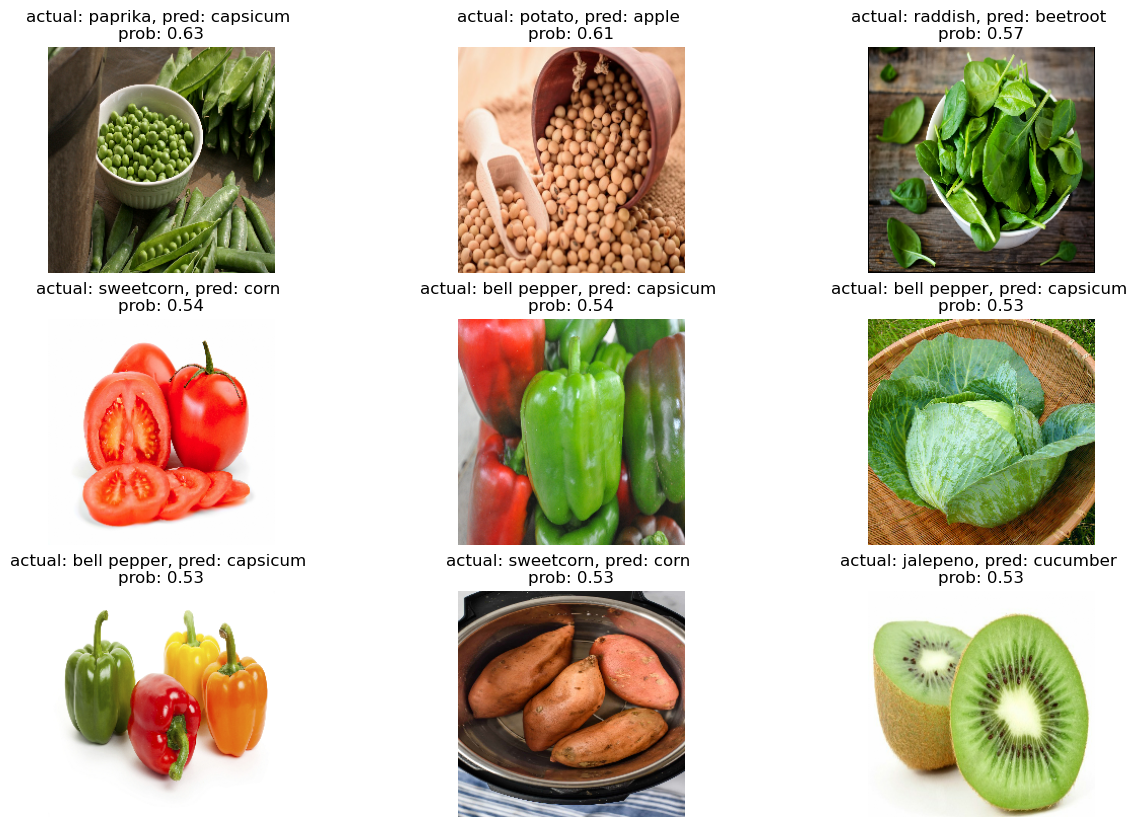

In [63]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

# **Test out the big dog model on test images as well as custom images of food** 


In [64]:
# Get custom food images filepaths
custom_food_images = ["custom_images/" + img_path for img_path in os.listdir("custom_images")]
custom_food_images

['custom_images/Bunch-of-bananas-67e91d5.jpg',
 'custom_images/cabbage.jpg',
 'custom_images/pomegranates.jpg',
 'custom_images/potato.jpg',
 'custom_images/spinach.jpg',
 'custom_images/turnip.jpg']

1/1 [==============================] - 0s 82ms/step


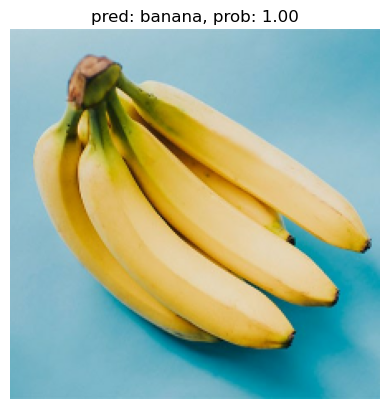

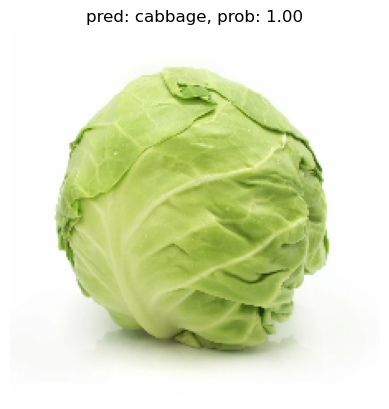

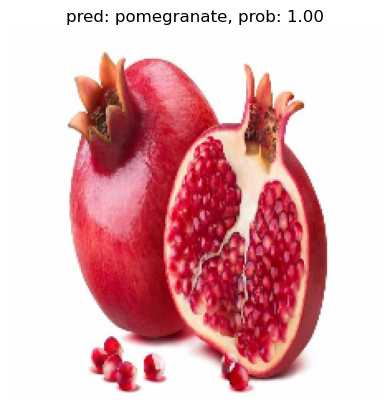

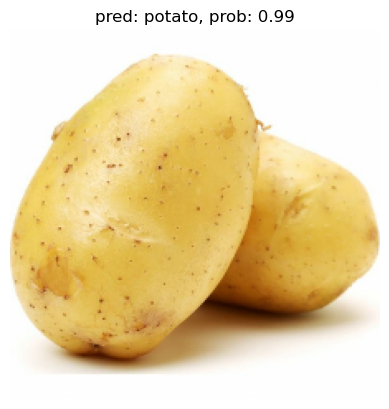

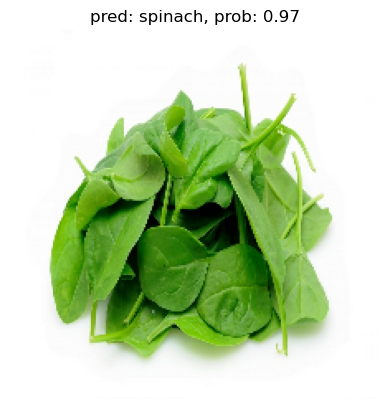

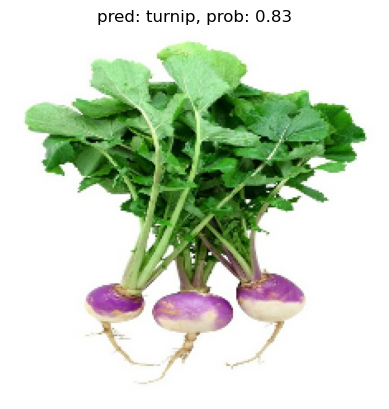

In [65]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)